In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from highlight_initializer import *
from baseline_evaluation import evaluate_baseline
from utils import *
import copy
from highlight_extractor import *
from parameters import *
import warnings
warnings.filterwarnings("ignore")

# Loading datasets

In [2]:
dota2_train_data = DataLoader('Dota2', 'train', **INITIAL_PARA)
dota2_test_data = DataLoader('Dota2', 'test', **INITIAL_PARA)
lol_train_data = DataLoader('LOL', 'train', **INITIAL_PARA)
lol_test_data = DataLoader('LOL', 'test', **INITIAL_PARA)

# Training models

In [3]:
dota2_model1 = train(dota2_train_data, [0])
dota2_model3 = train(dota2_train_data, [0, 1, 2])
dota2_model2 = train(dota2_train_data, [0, 1])
lol_model = train(lol_train_data, [0, 1, 2])

expander = Adjustment(dota2_train_data, **EXPAND)
expander.train()

# Exp for Figure 2(a)

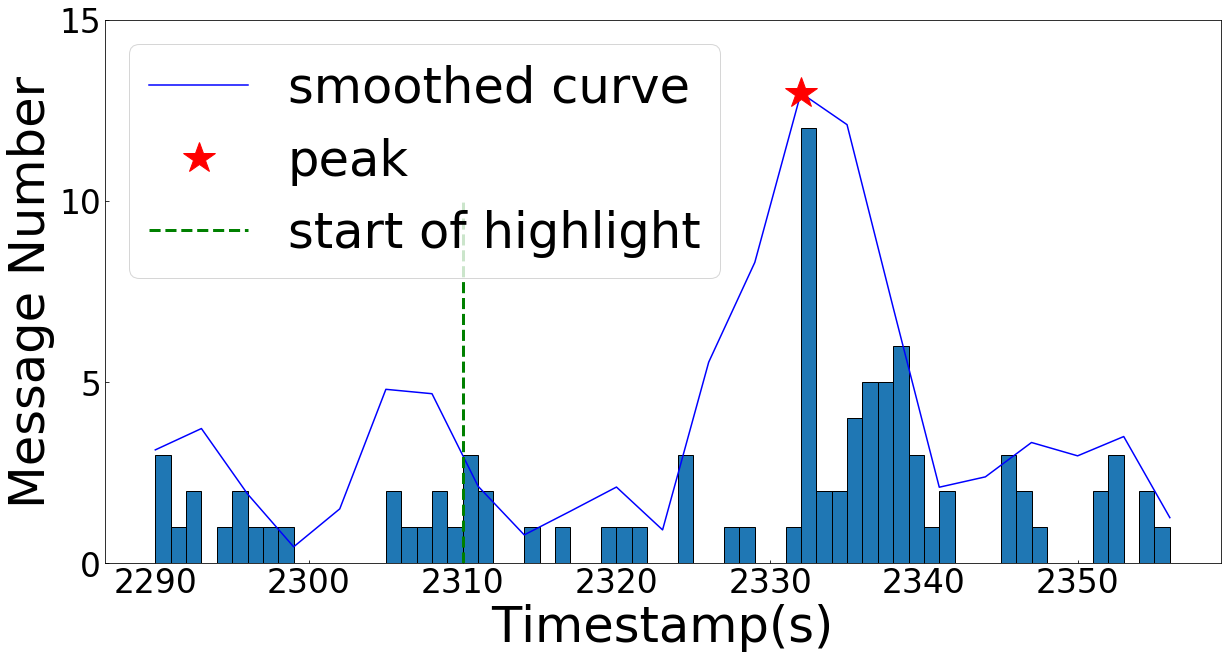

In [4]:
selected_file = 'sing_sing-2017-08-01-09h09m34s'
selected_time = ['038-42', '038-30', '038-45']
plot_peak(dota2_test_data, selected_file, sec(selected_time[0]), sec(selected_time[1]))

# Exp for Figure 2(b)

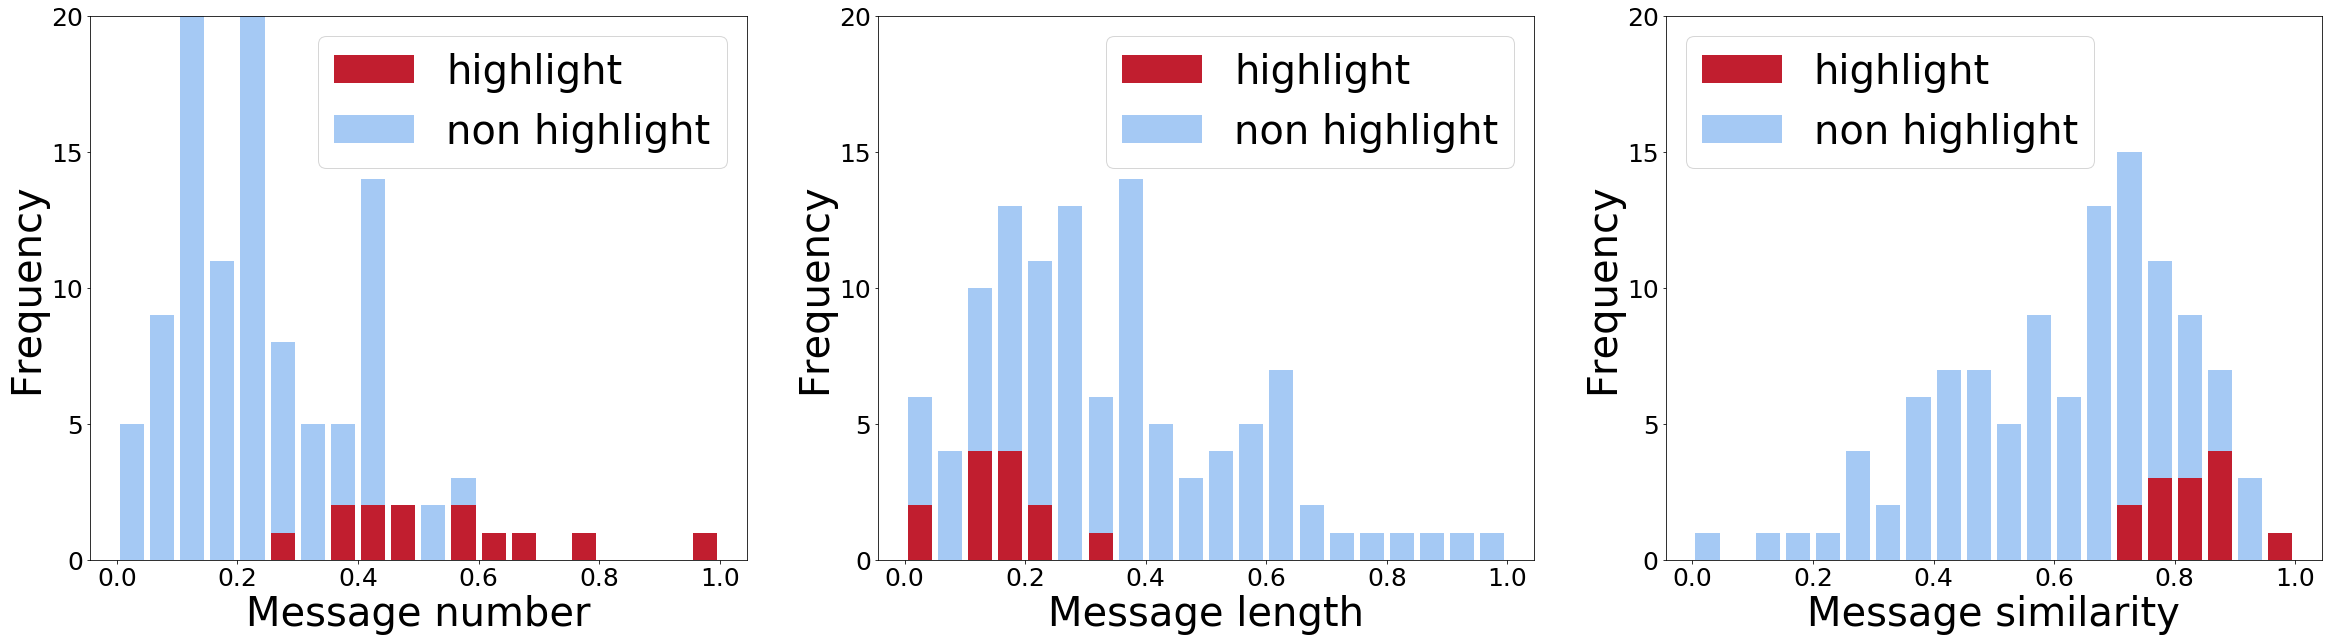

In [5]:
show_features(dota2_train_data)

# Exp for Figure 3

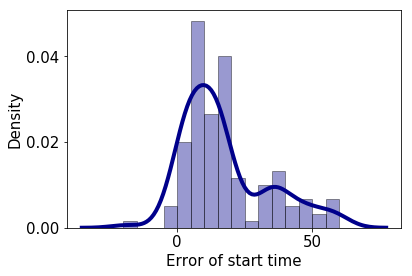

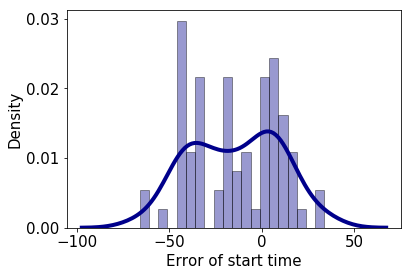

In [6]:
plot_behaviors("1")
plot_behaviors("2")

# Exp for Figure 6(a)

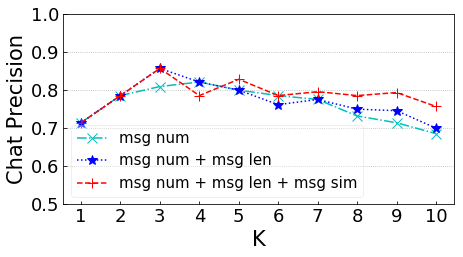

In [7]:
k = 10
dota2_test_data1 = copy.deepcopy(dota2_test_data)
dota2_test_data2 = copy.deepcopy(dota2_test_data)

apply_model(dota2_model1, dota2_test_data, 120, [4])
ML_num = dota2_test_data.predicted_labels
ML_num_precision = []

apply_model(dota2_model2, dota2_test_data1, 120, [4, 5])
ML_num_len = dota2_test_data1.predicted_labels
ML_num_len_precision = []

apply_model(dota2_model3, dota2_test_data2, 120, [4, 5, 6])
ML_num_len_sim = dota2_test_data2.predicted_labels
ML_num_len_sim_precision = []

gt = {}
for f in dota2_test_data.true_labels:
    gt[f] = [sec(j[0]) for j in dota2_test_data.true_labels[f]]

for i in range(1, k + 1):
    true_num = [0, 0 ,0]
    for f in gt:
        true_num[0] += len([p for p in ML_num[f][:i] if p[0] in gt[f]])
        true_num[1] += len([p for p in ML_num_len[f][:i] if p[0] in gt[f]])
        true_num[2] += len([p for p in ML_num_len_sim[f][:i] if p[0] in gt[f]])
    ML_num_precision.append(true_num[0] / float(i * len(gt)))
    ML_num_len_precision.append(true_num[1] / float(i * len(gt)))
    ML_num_len_sim_precision.append(true_num[2] / float(i * len(gt)))

prec_list = [[ML_num_precision, 'cx-.', 'msg num'],
             [ML_num_len_precision, '*b:', 'msg num + msg len'],
             [ML_num_len_sim_precision, '+r--', 'msg num + msg len + msg sim']
            ]


plot_precision(prec_list, 'K', 'Chat Precision', list(range(1, k + 1)), [0.5, 1.0], [0.5,0.6,0.7,0.8,0.9,1.0])

# Exp for Figure 6(b)

10


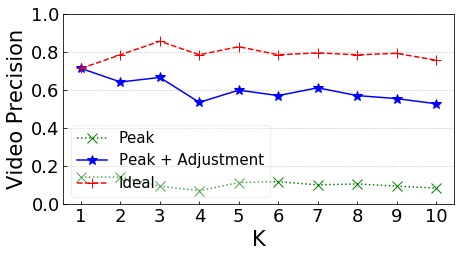

In [8]:
apply_model(dota2_model3, dota2_test_data, 120, [4, 5, 6])
expander.generate_peak(dota2_test_data, **EXPAND)
expander.apply(dota2_test_data)

k = 10

no_moving = []
moving = []
ideal = []
for i in range(1, k + 1):
    true_num = [0, 0, 0]
    for f in dota2_test_data.predicted_labels:
        true_labels = [sec(j[0]) for j in dota2_test_data.true_labels[f]]
        true_num[0] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[0] in true_labels])
        true_num[1] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-1] in dota2_test_data.gt[f]])       
        true_num[2] += len([p[0] for p in dota2_test_data.predicted_labels[f][:i] if p[-2] in dota2_test_data.gt[f]])
        
    no_moving.append(true_num[2] / float(i * len(dota2_test_data.predicted_labels)))
    moving.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))
    ideal.append(true_num[0] / float(i * len(dota2_test_data.predicted_labels)))


prec_list = [[no_moving, 'xg:', 'Peak'],
             [moving, '*b-', 'Peak + Adjustment'],
             [ideal, '+r--', 'Ideal']
            ]
print (len(prec_list[2][0]))
plot_precision(prec_list, 'K', 'Video Precision', list(range(1, k + 1)), [0, 1], np.arange(0.0, 1.1, 0.2))

# Exp for Figure 7

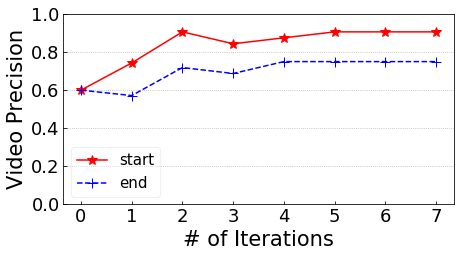

In [9]:
highlight_extractor = Highlight_Extractor(ORIGINAL_DATA)
highlight_extractor.process_all_iterations()

crowd_data = {}
for t in highlight_extractor.data_lineage:
    for m in highlight_extractor.data_lineage[t]:
        crowd_data[m] = highlight_extractor.data_lineage[t][m]

end_gt = {}
for f in dota2_test_data.gt:
    end_gt[f] = []
    for i in dota2_test_data.gt[f]:
        end_gt[f] += list(range(i, i + 11))
    end_gt[f] = list(set(end_gt[f]))
    

iternum = 7
pre = []
for i in range(0, iternum + 1):
    p = [0, 0, 0]
    for m in crowd_data:
        f = DOTA2_MOVIE_NAME_BY_ID[m]   
        l = len(crowd_data[m]) - 2
        s = 0
        e = 0
        if m in highlight_extractor.data_lineage['selected']:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i][1] > 0 else s + expander.const[1]
            else:
                s = crowd_data[m][-1][0]
                e = crowd_data[m][-1][1]
            p[2] += 1
            if s in dota2_test_data.gt[f]:
                p[0] += 1
            if e in end_gt[f]:
                p[1] += 1
        else:
            if i < l:
                s = crowd_data[m][i][0]
                e = crowd_data[m][i][1] if crowd_data[m][i - 1][1] > 0 else s + expander.const[1]
                p[2] += 1
                if s in dota2_test_data.gt[f]:
                    p[0] += 1
                if e in end_gt[f]:
                    p[1] += 1
    pre.append(p)
start = [i[0] / i[2] for i in pre]
end = [i[1] / i[2] for i in pre]

crowd_plot = [
    [start, '-r*', 'start'],
    [end, '--b+', 'end']
]

plot_precision(crowd_plot, '# of Iterations', 'Video Precision', list(range(0, iternum + 1)), [0, 1], np.arange(0, 1.1, 0.2))

# Exp for Figure 8

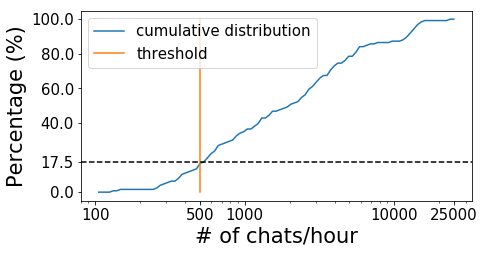

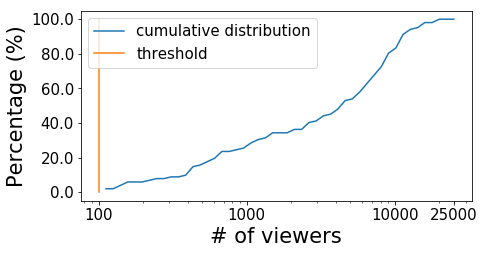

<Figure size 432x288 with 0 Axes>

In [10]:
plot_trends()

# Exp for Figure 9

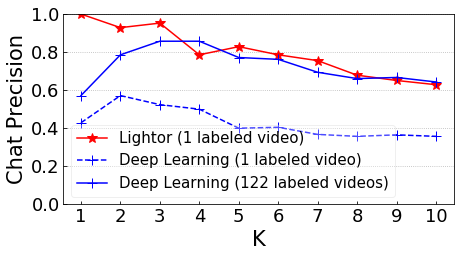

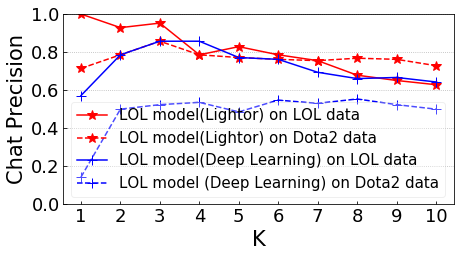

In [11]:
k = 10

lol_on_lol_DL_122 = evaluate_baseline(k, 'LOL_122_labels', lol_test_data.true_labels)
lol_on_lol_DL_1 = evaluate_baseline(k, 'LOL_1_label', lol_test_data.true_labels)
lol_on_dota_DL_122 = evaluate_baseline(k, 'Dota2_122_labels', dota2_test_data.true_labels)
lol_on_dota_DL_1 = evaluate_baseline(k, 'Dota2_1_label', dota2_test_data.true_labels)


lol_on_lol_lightor = []
lol_on_dota_lightor = []

lol_gt = {}
dota2_gt = {}

for f in lol_test_data.chat:
    lol_gt[f] = [j[0] for j in lol_test_data.true_labels[f]]
    
for f in dota2_test_data.chat:
    dota2_gt[f] = [j[0] for j in dota2_test_data.true_labels[f]]

apply_model(lol_model, lol_test_data, 120, [4, 5, 6])
apply_model(lol_model, dota2_test_data, 120, [4, 5, 6])
    
for i in range(1, k + 1):
    true_num = [0, 0]
    for f in lol_test_data.chat:
        pred = lol_test_data.predicted_labels[f][:i]
        true_num[0] += len([p for p in pred if time(p[0]) in lol_gt[f]])
        
    for f in dota2_test_data.chat:
        pred = dota2_test_data.predicted_labels[f][:i]
        true_num[1] += len([p for p in pred if time(p[0]) in dota2_gt[f]])
    lol_on_lol_lightor.append(true_num[0] / float(i * len(lol_test_data.predicted_labels)))
    lol_on_dota_lightor.append(true_num[1] / float(i * len(dota2_test_data.predicted_labels)))

data_size_plot = [
    [lol_on_lol_lightor, '-r*', 'Lightor (1 labeled video)'],
    [lol_on_lol_DL_1, '--b+', 'Deep Learning (1 labeled video)'],
    [lol_on_lol_DL_122, '-b+', 'Deep Learning (122 labeled videos)']
]

generalization_plot = [
    [lol_on_lol_lightor, '-r*', 'LOL model(Lightor) on LOL data'],
    [lol_on_dota_lightor, '--r*', 'LOL model(Lightor) on Dota2 data'],
    [lol_on_lol_DL_122, '-b+', 'LOL model(Deep Learning) on LOL data'],
    [lol_on_dota_DL_122, '--b+', 'LOL model (Deep Learning) on Dota2 data']
]

plot_precision(data_size_plot, 'K', 'Chat Precision', list(range(1, k + 1)), [0, 1], np.arange(0, 1.1, 0.2))
plot_precision(generalization_plot, 'K', 'Chat Precision', list(range(1, k + 1)), [0, 1], np.arange(0, 1.1, 0.2))